## What's this TensorFlow business?

You've written a lot of code in this assignment to provide a whole host of neural network functionality. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. You've also worked hard to make your code efficient and vectorized.

For the last part of this assignment, though, we're going to leave behind your beautiful codebase and instead migrate to one of two popular deep learning frameworks: in this instance, TensorFlow (or PyTorch, if you switch over to that notebook)

#### What is it?
TensorFlow is a system for executing computational graphs over Tensor objects, with native support for performing backpropogation for its Variables. In it, we work with Tensors which are n-dimensional arrays analogous to the numpy ndarray.

#### Why?

* Our code will now run on GPUs! Much faster training. Writing your own modules to run on GPUs is beyond the scope of this class, unfortunately.
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry. 

## How will I learn TensorFlow?

TensorFlow has many excellent tutorials available, including those from [Google themselves](https://www.tensorflow.org/get_started/get_started).

Otherwise, this notebook will walk you through much of what you need to do to train models in TensorFlow. See the end of the notebook for some links to helpful tutorials if you want to learn more or need further clarification on topics that aren't fully explained here.

## Load Datasets


In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Example Model

### Some useful utilities

. Remember that our image data is initially N x H x W x C, where:
* N is the number of datapoints
* H is the height of each image in pixels
* W is the height of each image in pixels
* C is the number of channels (usually 3: R, G, B)

This is the right way to represent the data when we are doing something like a 2D convolution, which needs spatial understanding of where the pixels are relative to each other. When we input image data into fully connected affine layers, however, we want each data example to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data.

### The example model itself

The first step to training your own model is defining its architecture.

Here's an example of a convolutional neural network defined in TensorFlow -- try to understand what each line is doing, remembering that each layer is composed upon the previous layer. We haven't trained anything yet - that'll come next - for now, we want you to understand how everything gets set up. 

In that example, you see 2D convolutional layers (Conv2d), ReLU activations, and fully-connected layers (Linear). You also see the Hinge loss function, and the Adam optimizer being used. 

Make sure you understand why the parameters of the Linear layer are 5408 and 10.

### TensorFlow Details
In TensorFlow, much like in our previous notebooks, we'll first specifically initialize our variables, and then our network model.

In [41]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def simple_model(X,y):
    # define our weights (e.g. init_two_layer_convnet)
    
    # setup variables
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    W1 = tf.get_variable("W1", shape=[5408, 10])
    b1 = tf.get_variable("b1", shape=[10])

    # define our graph (e.g. two_layer_convnet)
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,2,2,1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    h1_flat = tf.reshape(h1,[-1,5408])
    y_out = tf.matmul(h1_flat,W1) + b1
    return y_out

y_out = simple_model(X,y)

# define our loss
total_loss = tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.AdamOptimizer(5e-4) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)

TensorFlow supports many other layer types, loss functions, and optimizers - you will experiment with these next. Here's the official API documentation for these (if any of the parameters used above were unclear, this resource will also be helpful). 

* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers
* BatchNorm: https://www.tensorflow.org/api_docs/python/tf/contrib/layers/batch_norm

### Training the model on one epoch
While we have defined a graph of operations above, in order to execute TensorFlow Graphs, by feeding them input data and computing the results, we first need to create a `tf.Session` object. A session encapsulates the control and state of the TensorFlow runtime. For more information, see the TensorFlow [Getting started](https://www.tensorflow.org/get_started/get_started) guide.

Optionally we can also specify a device context such as `/cpu:0` or `/gpu:0`. For documentation on this behavior see [this TensorFlow guide](https://www.tensorflow.org/tutorials/using_gpu)

You should see a validation loss of around 0.4 to 0.6 and an accuracy of 0.30 to 0.35 below

In [42]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False, saver=None):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%X_train.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[i:i+batch_size].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
        if saver is not None:
            save_path = saver.save(sess, "models/epoch_%d" % e)
            print("Model saved in file: %s" % save_path)
    return total_loss,total_correct

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Iteration 0: with minibatch training loss = 12.1 and accuracy of 0.031
Iteration 100: with minibatch training loss = 0.953 and accuracy of 0.28
Iteration 200: with minibatch training loss = 0.757 and accuracy of 0.22
Iteration 300: with minibatch training loss = 0.557 and accuracy of 0.44
Iteration 400: with minibatch training loss = 0.519 and accuracy of 0.34
Iteration 500: with minibatch training loss = 0.526 and accuracy of 0.38
Iteration 600: with minibatch training loss = 0.391 and accuracy of 0.39
Iteration 700: with minibatch training loss = 0.523 and accuracy of 0.27
Epoch 1, Overall loss = 0.749 and accuracy of 0.304


Validation
Epoch 1, Overall loss = 0.49 and accuracy of 0.346


## Training a specific model

In this section, we're going to specify a model for you to construct. The goal here isn't to get good performance (that'll be next), but instead to get comfortable with understanding the TensorFlow documentation and configuring your own model. 

Using the code provided above as guidance, and using the following TensorFlow documentation, specify a model with the following architecture:

* 7x7 Convolutional Layer with 32 filters and stride of 1
* ReLU Activation Layer
* Spatial Batch Normalization Layer (trainable parameters, with scale and centering)
* 2x2 Max Pooling layer with a stride of 2
* Affine layer with 1024 output units
* ReLU Activation Layer
* Affine layer from 1024 input units to 10 outputs



In [92]:
# clear old variables
tf.reset_default_graph()
momentum = 0.9

# define our input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

# define model
def complex_model(X,y,is_training):
    W1 = tf.get_variable("W1", shape = [7, 7, 3, 32])
    b1 = tf.get_variable("b1", shape = [32])
    W2 = tf.get_variable("W2", shape = [5408, 1024])
    b2 = tf.get_variable("b2", shape = [1024])
    W3 = tf.get_variable("W3", shape = [1024, 10])
    b3 = tf.get_variable("b3", shape = [10])
    #pass

    x1 = tf.nn.conv2d(X, W1, [1, 1, 1, 1], "VALID")
    x1_prime = tf.nn.bias_add(x1, b1)
    x2 = tf.nn.relu(x1_prime)
    x3 = tf.layers.batch_normalization(x2, training=is_training)
    x4 = tf.nn.max_pool(x3, [1, 2, 2, 1], [1, 2, 2, 1], "VALID")
    x4_flat = tf.reshape(x4, shape=[-1, 5408])
    #x5 = tf
    x5 = tf.matmul(x4_flat, W2) + b2
    x6 = tf.nn.relu(x5)
    x7 = tf.matmul(x6, W3) + b3
    return x7

y_out = complex_model(X,y,is_training)

To make sure you're doing the right thing, use the following tool to check the dimensionality of your output (it should be 64 x 10, since our batches have size 64 and the output of the final affine layer should be 10, corresponding to our 10 classes):

In [93]:
# Now we're going to feed a random batch into the model 
# and make sure the output is the right size
x = np.random.randn(64, 32, 32,3)
with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0"
        tf.global_variables_initializer().run()

        ans = sess.run(y_out,feed_dict={X:x,is_training:True})
        %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
        print(ans.shape)
        print(np.array_equal(ans.shape, np.array([64, 10])))

100 loops, best of 3: 3.65 ms per loop
(64, 10)
True


You should see the following from the run above 

`(64, 10)`

`True`

### GPU!

Now, we're going to try and start the model under the GPU device, the rest of the code stays unchanged and all our variables and operations will be computed using accelerated code paths. However, if there is no GPU, we get a Python exception and have to rebuild our graph. On a dual-core CPU, you might see around 50-80ms/batch running the above, while the Google Cloud GPUs (run below) should be around 2-5ms/batch.

In [94]:
try:
    with tf.Session() as sess:
        with tf.device("/gpu:0") as dev: #"/cpu:0" or "/gpu:0"
            tf.global_variables_initializer().run()

            ans = sess.run(y_out,feed_dict={X:x,is_training:True})
            %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
except tf.errors.InvalidArgumentError:
    print("no gpu found, please use Google Cloud if you want GPU acceleration")    
    # rebuild the graph
    # trying to start a GPU throws an exception 
    # and also trashes the original graph
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, 32, 32, 3])
    y = tf.placeholder(tf.int64, [None])
    is_training = tf.placeholder(tf.bool)
    y_out = complex_model(X,y,is_training)

100 loops, best of 3: 3.56 ms per loop


You should observe that even a simple forward pass like this is significantly faster on the GPU. So for the rest of the assignment (and when you go train your models in assignment 3 and your project!), you should use GPU devices. However, with TensorFlow, the default device is a GPU if one is available, and a CPU otherwise, so we can skip the device specification from now on.

### Train the model.

Now that you've seen how to define a model and do a single forward pass of some data through it, let's  walk through how you'd actually train one whole epoch over your training data (using the complex_model you created provided above).

Make sure you understand how each TensorFlow function used below corresponds to what you implemented in your custom neural network implementation.

First, set up an **RMSprop optimizer** (using a 1e-3 learning rate) and a **cross-entropy loss** function. See the TensorFlow documentation for more information
* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers

In [95]:
# Inputs
#     y_out: is what your model computes
#     y: is your TensorFlow variable with label information
# Outputs
#    mean_loss: a TensorFlow variable (scalar) with numerical loss
#    optimizer: a TensorFlow optimizer
# This should be ~3 lines of code!
lr = 1e-4
total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y, 10), y_out)
mean_loss = tf.reduce_mean(total_loss)
optimizer = tf.train.RMSPropOptimizer(lr)
pass

In [96]:
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

### Train the model
Below we'll create a session and train the model over one epoch. You should see a loss of 1.4 to 1.8 and an accuracy of 0.4 to 0.5. There will be some variation due to random seeds and differences in initialization

In [16]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step)

Training
Iteration 0: with minibatch training loss = 3.04 and accuracy of 0.12
Iteration 100: with minibatch training loss = 2.04 and accuracy of 0.31
Iteration 200: with minibatch training loss = 1.41 and accuracy of 0.5
Iteration 300: with minibatch training loss = 1.78 and accuracy of 0.38
Iteration 400: with minibatch training loss = 1.45 and accuracy of 0.5
Iteration 500: with minibatch training loss = 1.45 and accuracy of 0.55
Iteration 600: with minibatch training loss = 1.49 and accuracy of 0.47
Iteration 700: with minibatch training loss = 1.28 and accuracy of 0.62
Epoch 1, Overall loss = 1.63 and accuracy of 0.456


(1.6328374492878817, 0.45589795918367348)

### Check the accuracy of the model.

Let's see the train and test code in action -- feel free to use these methods when evaluating the models you develop below. You should see a loss of 1.3 to 1.5 with an accuracy of 0.45 to 0.55.

In [17]:
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Validation
Epoch 1, Overall loss = 1.26 and accuracy of 0.566


(1.2646788330078125, 0.56599999999999995)

## Train a _great_ model on CIFAR-10!

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves ** >= 70% accuracy on the validation set** of CIFAR-10. You can use the `run_model` function from above.

### Things you should try:
- **Filter size**: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Use TensorFlow Scope**: Use TensorFlow scope and/or [tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers) to make it easier to write deeper networks. See [this tutorial](https://www.tensorflow.org/tutorials/layers) for making how to use `tf.layers`. 
- **Use Learning Rate Decay**: [As the notes point out](http://cs231n.github.io/neural-networks-3/#anneal), decaying the learning rate might help the model converge. Feel free to decay every epoch, when loss doesn't change over an entire epoch, or any other heuristic you find appropriate. See the [Tensorflow documentation](https://www.tensorflow.org/versions/master/api_guides/python/train#Decaying_the_learning_rate) for learning rate decay.
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use [Dropout as in the TensorFlow MNIST tutorial](https://www.tensorflow.org/get_started/mnist/pros)

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and we'll save the test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at **>= 70% accuracy on the validation set**. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training and validation set accuracies for your final trained network.

Have fun and happy training!

In [51]:
def pre_activation_unit(X, is_training):
    x = tf.nn.relu(X)
    xx = tf.layers.batch_normalization(x, training=is_training)
    return xx

def residual_unit(X, is_training, filter_size):
    F = filter_size
    conv_W = tf.get_variable("conv_W", shape = [3, 3, F, F],
                        initializer = tf.contrib.layers.xavier_initializer())
    
    x = pre_activation_unit(X, is_training)
    paddings = [[0, 0], [1, 1], [1, 1], [0, 0]]
    xx = tf.pad(x, paddings, "CONSTANT")
    y = tf.nn.conv2d(xx, conv_W, [1, 1, 1, 1], "VALID")
    #x3 = tf.layers.batch_normalization(x2, training=is_training)
    #x3 = tf.layers.batch_normalization(x1, training=is_training)
    return y

def residual_unit_down(X, is_training, filter_size, scope):
    F = filter_size
    with tf.variable_scope(scope):
        W1 = tf.get_variable("W1", shape = [3, 3, F, 2 * F],
                             initializer = tf.contrib.layers.xavier_initializer())
        
        x = pre_activation_unit(X, is_training)
        
        paddings = [[0, 0], [1, 1], [1, 1], [0, 0]]
        xx = tf.pad(x, paddings, "CONSTANT")
        y = tf.nn.conv2d(xx, W1, [1, 2, 2, 1], "VALID")
        #x2 = tf.nn.bias_add(x1, b1)
        #x3 = tf.layers.batch_normalization(x2, training=is_training)
        #x3 = tf.layers.batch_normalization(x1, training=is_training)
        
        x4 = residual_unit(y, is_training, 2 * F)
        # project X
        x5 = tf.nn.avg_pool(X, [1, 2, 2, 1], [1, 2, 2, 1], "VALID")
        x6 = tf.pad(x5, [[0, 0], [0, 0], [0, 0], [F // 2, F // 2]], "CONSTANT")
        return x4 + x6
    
def residual_net_model(X, y, is_training, n = 3):
    # define the first layer
    with tf.variable_scope('init'):
        #x = pre_activation_unit(X, is_training)
        x = X
        W = tf.get_variable("W", shape = [3, 3, 3, 16], 
                            initializer = tf.contrib.layers.xavier_initializer())
        x = tf.pad(x, [[0, 0], [1, 1], [1, 1], [0, 0]], "CONSTANT")
        x = tf.nn.conv2d(x, W, [1, 1, 1, 1], "VALID")
    # define 2n 32-by-32-by-16 layers
    for i in range(3):
        orig_x = x
        with tf.variable_scope('first_%d' % i):
            x = residual_unit(x, is_training, 16)
        with tf.variable_scope('first_%d_skip' % i):
            x = residual_unit(x, is_training, 16)
            x = x + orig_x
    # define 2n 16-by-16-by-32 layers
    x = residual_unit_down(x, is_training, 16, 'second_init')
    for i in range(2):
        orig_x = x
        with tf.variable_scope('second_%d' % i):
            x = residual_unit(x, is_training, 32)
        with tf.variable_scope('second_%d_skip' % i):
            x = residual_unit(x, is_training, 32)
            x = x + orig_x
    # define 2n 8-by-8-by-64 layers
    x = residual_unit_down(x, is_training, 32, 'third_init')
    for i in range(2):
        orig_x = x
        with tf.variable_scope('third_%d' % i):
            x = residual_unit(x, is_training, 64)
        with tf.variable_scope('third_%d_skip' % i):
            x = residual_unit(x, is_training, 64)
            x = x + orig_x
    # last avg_pool and fc
    with tf.variable_scope('last_pool'):
        x = tf.reduce_mean(x, [1, 2])
    with tf.variable_scope('last_fc'):
        x = tf.reshape(x, [-1, 64])
        W = tf.get_variable('W', [64, 10], 
                            initializer = tf.contrib.layers.xavier_initializer())
        b = tf.get_variable('b', [10])
        y = tf.matmul(x, W) + b
    return y

In [29]:
tf.reset_default_graph()

H, W, C = 32, 32, 3
X = tf.placeholder(tf.float32, [None, H, W, C])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = residual_net_model(X, y, is_training)
# Now we're going to feed a random batch into the model 
# and make sure the output is the right size
x = np.random.randn(100, H, W, C)
with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0"
        tf.global_variables_initializer().run()

        ans = sess.run(y_out,feed_dict={X:x,is_training:True})
        %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
        print(ans.shape)
        print(np.array_equal(ans.shape, np.array([100, 10])))

10 loops, best of 3: 34.1 ms per loop
(100, 10)
True


In [ ]:
learning_rate = 1.0 / 10 ** np.linspace(1, 5, 5)
regularization_strength = 1.0/10 ** np.linspace(5, 1, 5)

for lr in learning_rate:
    for reg in regularization_strength:
        
        tf.reset_default_graph()

        X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        y = tf.placeholder(tf.int64, [None])
        is_training = tf.placeholder(tf.bool)

        y_out = residual_net_model(X, y, is_training, 5)

        def mean_loss_function(y_out, y, reg = 0.0001):
            costs = []
            for var in tf.trainable_variables():
                if var.op.name.find('W') > 0:
                    costs.append(tf.nn.l2_loss(var))
            logit = tf.nn.softmax(y_out)
            total_loss = tf.nn.softmax_cross_entropy_with_logits(logits=logit, labels=tf.one_hot(y, 10))
            res = tf.reduce_mean(total_loss)
            res += tf.multiply(reg, tf.add_n(costs))
            return res

        mean_loss = mean_loss_function(y_out, y)
        mom = 0.9
        optimizer = tf.train.MomentumOptimizer(lr, mom)

        # batch normalization in tensorflow requires this extra dependency
        extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(extra_update_ops):
            train_step = optimizer.minimize(mean_loss)
            
        # run for one epoch
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess, y_out, mean_loss, X_train, y_train, 1, 64, 100, train_step)
        print('Validation for (%f, %f)' % (lr, reg))
        run_model(sess, y_out, mean_loss, X_val, y_val, 1, 64, None, False, saver)

Iteration 0: with minibatch training loss = 19.5 and accuracy of 0.078
Iteration 100: with minibatch training loss = 6.88 and accuracy of 0.14
Iteration 200: with minibatch training loss = 5.46 and accuracy of 0.31
Iteration 300: with minibatch training loss = 4.95 and accuracy of 0.31
Iteration 400: with minibatch training loss = 4.88 and accuracy of 0.34
Iteration 500: with minibatch training loss = 4.7 and accuracy of 0.41
Iteration 600: with minibatch training loss = 4.77 and accuracy of 0.33
Iteration 700: with minibatch training loss = 4.48 and accuracy of 0.53
Epoch 1, Overall loss = 6.01 and accuracy of 0.341


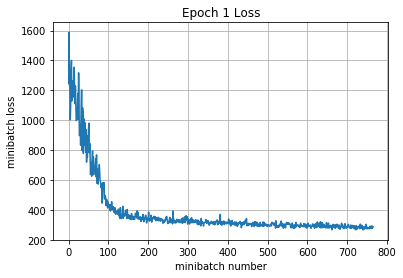

Validation
Epoch 1, Overall loss = 4.52 and accuracy of 0.453
Model saved in file: models/epoch_0
Iteration 0: with minibatch training loss = 4.62 and accuracy of 0.41
Iteration 100: with minibatch training loss = 4.37 and accuracy of 0.42
Iteration 200: with minibatch training loss = 4.28 and accuracy of 0.47
Iteration 300: with minibatch training loss = 4.17 and accuracy of 0.47
Iteration 400: with minibatch training loss = 3.88 and accuracy of 0.56
Iteration 500: with minibatch training loss = 4.04 and accuracy of 0.56
Iteration 600: with minibatch training loss = 4.06 and accuracy of 0.5
Iteration 700: with minibatch training loss = 3.89 and accuracy of 0.52
Epoch 1, Overall loss = 4.06 and accuracy of 0.492


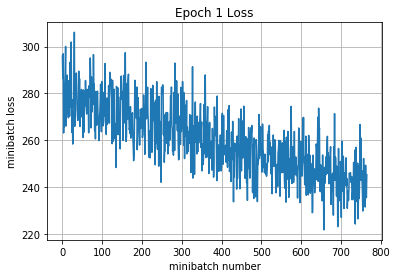

Validation
Epoch 1, Overall loss = 3.86 and accuracy of 0.534
Model saved in file: models/epoch_1
Iteration 0: with minibatch training loss = 3.92 and accuracy of 0.47
Iteration 100: with minibatch training loss = 3.64 and accuracy of 0.5
Iteration 200: with minibatch training loss = 3.48 and accuracy of 0.56
Iteration 300: with minibatch training loss = 3.55 and accuracy of 0.55
Iteration 400: with minibatch training loss = 3.61 and accuracy of 0.48
Iteration 500: with minibatch training loss = 3.21 and accuracy of 0.73
Iteration 600: with minibatch training loss = 3.5 and accuracy of 0.53
Iteration 700: with minibatch training loss = 3.47 and accuracy of 0.44
Epoch 1, Overall loss = 3.5 and accuracy of 0.558


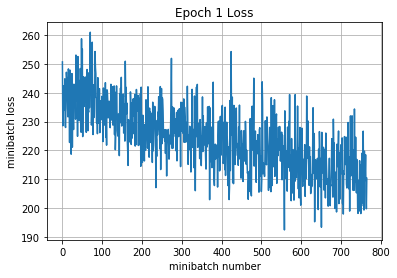

Validation
Epoch 1, Overall loss = 3.39 and accuracy of 0.562
Model saved in file: models/epoch_2
Iteration 0: with minibatch training loss = 3.13 and accuracy of 0.73
Iteration 100: with minibatch training loss = 3.12 and accuracy of 0.56
Iteration 200: with minibatch training loss = 3.38 and accuracy of 0.5
Iteration 300: with minibatch training loss = 3.27 and accuracy of 0.53
Iteration 400: with minibatch training loss = 3.09 and accuracy of 0.58
Iteration 500: with minibatch training loss = 2.96 and accuracy of 0.64
Iteration 600: with minibatch training loss = 2.88 and accuracy of 0.72
Iteration 700: with minibatch training loss = 2.95 and accuracy of 0.5
Epoch 1, Overall loss = 3.08 and accuracy of 0.6


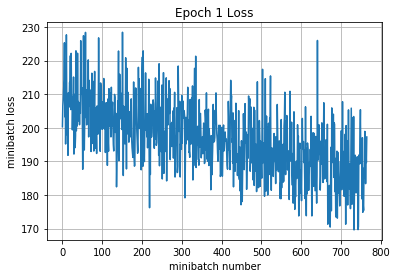

Validation
Epoch 1, Overall loss = 3.04 and accuracy of 0.587
Model saved in file: models/epoch_3
Iteration 0: with minibatch training loss = 3.06 and accuracy of 0.55
Iteration 100: with minibatch training loss = 2.71 and accuracy of 0.72
Iteration 200: with minibatch training loss = 2.79 and accuracy of 0.64
Iteration 300: with minibatch training loss = 2.64 and accuracy of 0.67
Iteration 400: with minibatch training loss = 2.67 and accuracy of 0.61
Iteration 500: with minibatch training loss = 2.61 and accuracy of 0.61
Iteration 600: with minibatch training loss = 2.64 and accuracy of 0.66
Iteration 700: with minibatch training loss = 2.61 and accuracy of 0.58
Epoch 1, Overall loss = 2.74 and accuracy of 0.632


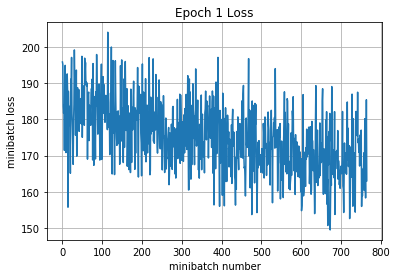

Validation
Epoch 1, Overall loss = 2.75 and accuracy of 0.615
Model saved in file: models/epoch_4
Iteration 0: with minibatch training loss = 2.74 and accuracy of 0.52
Iteration 100: with minibatch training loss = 2.75 and accuracy of 0.62
Iteration 200: with minibatch training loss = 2.42 and accuracy of 0.72
Iteration 300: with minibatch training loss = 2.56 and accuracy of 0.62
Iteration 400: with minibatch training loss = 2.71 and accuracy of 0.56
Iteration 500: with minibatch training loss = 2.55 and accuracy of 0.61
Iteration 600: with minibatch training loss = 2.26 and accuracy of 0.72
Iteration 700: with minibatch training loss = 2.36 and accuracy of 0.66
Epoch 1, Overall loss = 2.47 and accuracy of 0.658


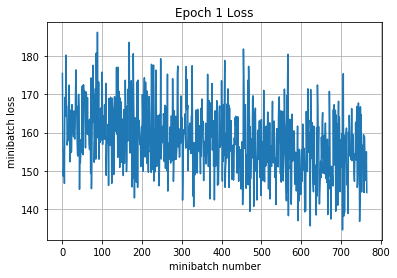

Validation
Epoch 1, Overall loss = 2.53 and accuracy of 0.635
Model saved in file: models/epoch_5
Iteration 0: with minibatch training loss = 2.22 and accuracy of 0.78
Iteration 100: with minibatch training loss = 2.22 and accuracy of 0.72
Iteration 200: with minibatch training loss = 2.14 and accuracy of 0.73
Iteration 300: with minibatch training loss = 2.24 and accuracy of 0.67
Iteration 400: with minibatch training loss = 2.5 and accuracy of 0.56
Iteration 500: with minibatch training loss = 2.17 and accuracy of 0.77
Iteration 600: with minibatch training loss = 2.21 and accuracy of 0.69
Iteration 700: with minibatch training loss = 2.39 and accuracy of 0.66
Epoch 1, Overall loss = 2.25 and accuracy of 0.684


Validation
Epoch 1, Overall loss = 2.35 and accuracy of 0.64
Model saved in file: models/epoch_6
Iteration 0: with minibatch training loss = 2 and accuracy of 0.77
Iteration 100: with minibatch training loss = 1.83 and accuracy of 0.8
Iteration 200: with minibatch training loss = 2 and accuracy of 0.77
Iteration 300: with minibatch training loss = 2.2 and accuracy of 0.55
Iteration 400: with minibatch training loss = 2.07 and accuracy of 0.69
Iteration 500: with minibatch training loss = 2.05 and accuracy of 0.77
Iteration 600: with minibatch training loss = 2.09 and accuracy of 0.69
Iteration 700: with minibatch training loss = 1.91 and accuracy of 0.69
Epoch 1, Overall loss = 2.07 and accuracy of 0.707


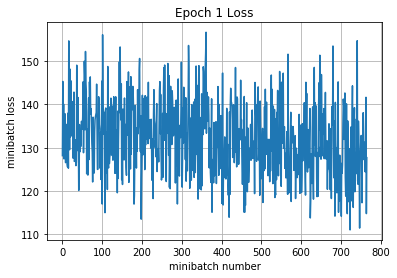

Validation
Epoch 1, Overall loss = 2.23 and accuracy of 0.646
Model saved in file: models/epoch_7
Iteration 0: with minibatch training loss = 1.97 and accuracy of 0.7
Iteration 100: with minibatch training loss = 2.05 and accuracy of 0.7
Iteration 200: with minibatch training loss = 1.81 and accuracy of 0.77
Iteration 300: with minibatch training loss = 1.71 and accuracy of 0.8
Iteration 400: with minibatch training loss = 1.75 and accuracy of 0.8
Iteration 500: with minibatch training loss = 1.95 and accuracy of 0.69
Iteration 600: with minibatch training loss = 1.99 and accuracy of 0.7
Iteration 700: with minibatch training loss = 1.92 and accuracy of 0.75
Epoch 1, Overall loss = 1.91 and accuracy of 0.726


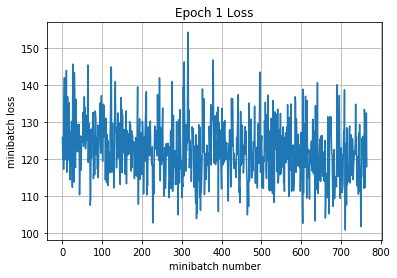

Validation
Epoch 1, Overall loss = 2.06 and accuracy of 0.663
Model saved in file: models/epoch_8
Iteration 0: with minibatch training loss = 1.79 and accuracy of 0.75
Iteration 100: with minibatch training loss = 1.87 and accuracy of 0.78
Iteration 200: with minibatch training loss = 1.77 and accuracy of 0.73
Iteration 300: with minibatch training loss = 1.64 and accuracy of 0.88
Iteration 400: with minibatch training loss = 1.75 and accuracy of 0.78
Iteration 500: with minibatch training loss = 1.72 and accuracy of 0.77
Iteration 600: with minibatch training loss = 1.72 and accuracy of 0.7
Iteration 700: with minibatch training loss = 1.65 and accuracy of 0.83
Epoch 1, Overall loss = 1.78 and accuracy of 0.745


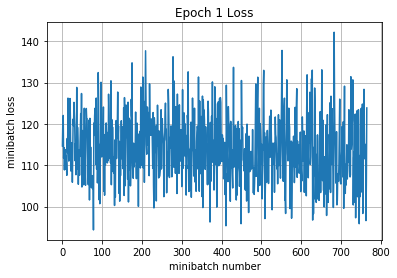

Validation
Epoch 1, Overall loss = 1.96 and accuracy of 0.677
Model saved in file: models/epoch_9
Iteration 0: with minibatch training loss = 1.87 and accuracy of 0.72
Iteration 100: with minibatch training loss = 1.68 and accuracy of 0.77
Iteration 200: with minibatch training loss = 1.84 and accuracy of 0.7
Iteration 300: with minibatch training loss = 1.75 and accuracy of 0.78
Iteration 400: with minibatch training loss = 1.8 and accuracy of 0.77
Iteration 500: with minibatch training loss = 1.75 and accuracy of 0.73
Iteration 600: with minibatch training loss = 2.03 and accuracy of 0.61
Iteration 700: with minibatch training loss = 1.66 and accuracy of 0.75
Epoch 1, Overall loss = 1.67 and accuracy of 0.761


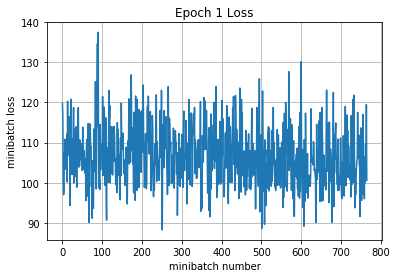

Validation
Epoch 1, Overall loss = 1.92 and accuracy of 0.676
Iteration 0: with minibatch training loss = 1.48 and accuracy of 0.81
Iteration 100: with minibatch training loss = 1.57 and accuracy of 0.77
Iteration 200: with minibatch training loss = 1.5 and accuracy of 0.8
Iteration 300: with minibatch training loss = 1.58 and accuracy of 0.77
Iteration 400: with minibatch training loss = 1.52 and accuracy of 0.77
Iteration 500: with minibatch training loss = 1.57 and accuracy of 0.75
Iteration 600: with minibatch training loss = 1.71 and accuracy of 0.72
Iteration 700: with minibatch training loss = 1.34 and accuracy of 0.89
Epoch 1, Overall loss = 1.57 and accuracy of 0.779


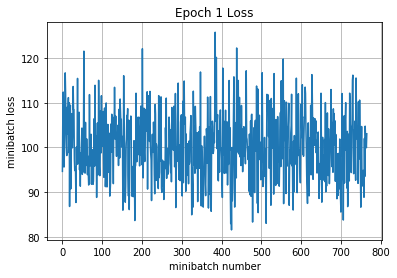

Validation
Epoch 1, Overall loss = 1.86 and accuracy of 0.679
Model saved in file: models/epoch_11
Iteration 0: with minibatch training loss = 1.37 and accuracy of 0.89
Iteration 100: with minibatch training loss = 1.35 and accuracy of 0.84
Iteration 200: with minibatch training loss = 1.45 and accuracy of 0.77
Iteration 300: with minibatch training loss = 1.66 and accuracy of 0.73
Iteration 400: with minibatch training loss = 1.47 and accuracy of 0.73
Iteration 500: with minibatch training loss = 1.41 and accuracy of 0.81
Iteration 600: with minibatch training loss = 1.49 and accuracy of 0.8
Iteration 700: with minibatch training loss = 1.35 and accuracy of 0.8
Epoch 1, Overall loss = 1.48 and accuracy of 0.793


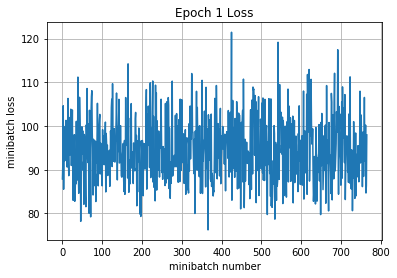

Validation
Epoch 1, Overall loss = 1.82 and accuracy of 0.683
Model saved in file: models/epoch_12
Iteration 0: with minibatch training loss = 1.44 and accuracy of 0.83
Iteration 100: with minibatch training loss = 1.31 and accuracy of 0.81
Iteration 200: with minibatch training loss = 1.32 and accuracy of 0.84
Iteration 300: with minibatch training loss = 1.39 and accuracy of 0.84
Iteration 400: with minibatch training loss = 1.4 and accuracy of 0.8
Iteration 500: with minibatch training loss = 1.31 and accuracy of 0.81
Iteration 600: with minibatch training loss = 1.38 and accuracy of 0.83
Iteration 700: with minibatch training loss = 1.3 and accuracy of 0.88
Epoch 1, Overall loss = 1.4 and accuracy of 0.805


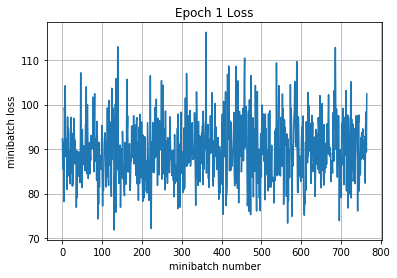

Validation
Epoch 1, Overall loss = 1.76 and accuracy of 0.697
Model saved in file: models/epoch_13
Iteration 0: with minibatch training loss = 1.2 and accuracy of 0.84
Iteration 100: with minibatch training loss = 1.35 and accuracy of 0.83
Iteration 200: with minibatch training loss = 1.44 and accuracy of 0.77
Iteration 300: with minibatch training loss = 1.45 and accuracy of 0.77
Iteration 400: with minibatch training loss = 1.35 and accuracy of 0.8
Iteration 500: with minibatch training loss = 1.44 and accuracy of 0.73
Iteration 600: with minibatch training loss = 1.31 and accuracy of 0.84
Iteration 700: with minibatch training loss = 1.43 and accuracy of 0.77
Epoch 1, Overall loss = 1.33 and accuracy of 0.823


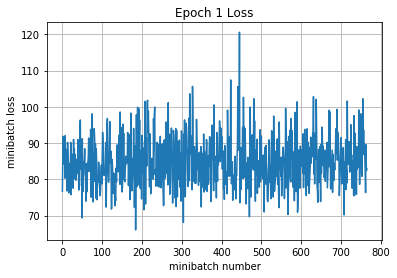

Validation
Epoch 1, Overall loss = 1.79 and accuracy of 0.668
Iteration 0: with minibatch training loss = 1.14 and accuracy of 0.91
Iteration 100: with minibatch training loss = 1.28 and accuracy of 0.92
Iteration 200: with minibatch training loss = 1.23 and accuracy of 0.89
Iteration 300: with minibatch training loss = 1.31 and accuracy of 0.83
Iteration 400: with minibatch training loss = 1.3 and accuracy of 0.75
Iteration 500: with minibatch training loss = 1.21 and accuracy of 0.83
Iteration 600: with minibatch training loss = 1.21 and accuracy of 0.83
Iteration 700: with minibatch training loss = 1.08 and accuracy of 0.88
Epoch 1, Overall loss = 1.27 and accuracy of 0.834


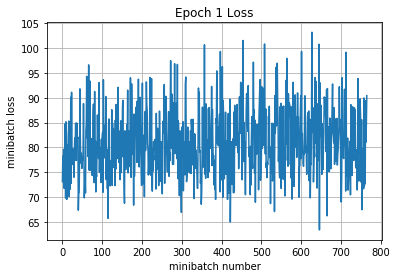

Validation
Epoch 1, Overall loss = 1.78 and accuracy of 0.695
Iteration 0: with minibatch training loss = 1.05 and accuracy of 0.98
Iteration 100: with minibatch training loss = 1.32 and accuracy of 0.78
Iteration 200: with minibatch training loss = 1.16 and accuracy of 0.86
Iteration 300: with minibatch training loss = 1.24 and accuracy of 0.84
Iteration 400: with minibatch training loss = 0.994 and accuracy of 0.94
Iteration 500: with minibatch training loss = 1.05 and accuracy of 0.92
Iteration 600: with minibatch training loss = 1.13 and accuracy of 0.88
Iteration 700: with minibatch training loss = 1.32 and accuracy of 0.75
Epoch 1, Overall loss = 1.21 and accuracy of 0.848


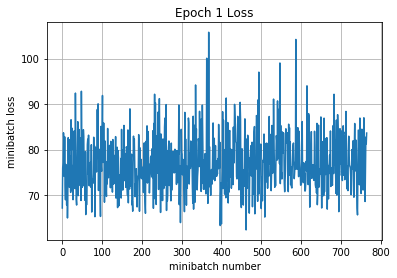

Validation
Epoch 1, Overall loss = 1.75 and accuracy of 0.688
Iteration 0: with minibatch training loss = 1.25 and accuracy of 0.81
Iteration 100: with minibatch training loss = 1.18 and accuracy of 0.88
Iteration 200: with minibatch training loss = 1.07 and accuracy of 0.89
Iteration 300: with minibatch training loss = 1.06 and accuracy of 0.91
Iteration 400: with minibatch training loss = 1.05 and accuracy of 0.92
Iteration 500: with minibatch training loss = 1.22 and accuracy of 0.78
Iteration 600: with minibatch training loss = 1.2 and accuracy of 0.86
Iteration 700: with minibatch training loss = 1.13 and accuracy of 0.88
Epoch 1, Overall loss = 1.15 and accuracy of 0.86


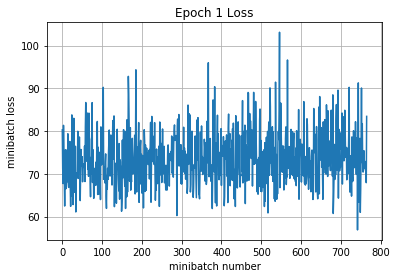

Validation
Epoch 1, Overall loss = 1.69 and accuracy of 0.706
Model saved in file: models/epoch_17
Iteration 0: with minibatch training loss = 1.08 and accuracy of 0.83
Iteration 100: with minibatch training loss = 1.08 and accuracy of 0.88
Iteration 200: with minibatch training loss = 1.15 and accuracy of 0.83
Iteration 300: with minibatch training loss = 1.11 and accuracy of 0.89
Iteration 400: with minibatch training loss = 1.21 and accuracy of 0.83
Iteration 500: with minibatch training loss = 1.39 and accuracy of 0.73
Iteration 600: with minibatch training loss = 1.09 and accuracy of 0.84
Iteration 700: with minibatch training loss = 0.962 and accuracy of 0.91
Epoch 1, Overall loss = 1.1 and accuracy of 0.871


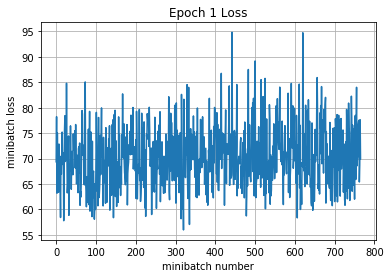

Validation
Epoch 1, Overall loss = 1.68 and accuracy of 0.694
Iteration 0: with minibatch training loss = 1.01 and accuracy of 0.88
Iteration 100: with minibatch training loss = 1.08 and accuracy of 0.86
Iteration 200: with minibatch training loss = 1.02 and accuracy of 0.92
Iteration 300: with minibatch training loss = 1.13 and accuracy of 0.86
Iteration 400: with minibatch training loss = 1.21 and accuracy of 0.84
Iteration 500: with minibatch training loss = 1.11 and accuracy of 0.83
Iteration 600: with minibatch training loss = 0.991 and accuracy of 0.89
Iteration 700: with minibatch training loss = 1.09 and accuracy of 0.86
Epoch 1, Overall loss = 1.05 and accuracy of 0.88


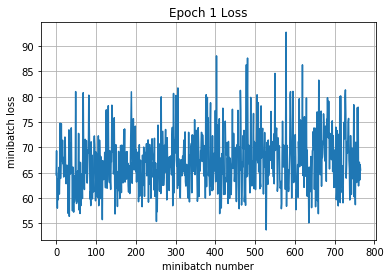

Validation
Epoch 1, Overall loss = 1.7 and accuracy of 0.698
Iteration 0: with minibatch training loss = 0.977 and accuracy of 0.89
Iteration 100: with minibatch training loss = 1.09 and accuracy of 0.84
Iteration 200: with minibatch training loss = 1.01 and accuracy of 0.91
Iteration 300: with minibatch training loss = 0.883 and accuracy of 0.95
Iteration 400: with minibatch training loss = 1.02 and accuracy of 0.86
Iteration 500: with minibatch training loss = 0.918 and accuracy of 0.92
Iteration 600: with minibatch training loss = 1.2 and accuracy of 0.84
Iteration 700: with minibatch training loss = 0.97 and accuracy of 0.91
Epoch 1, Overall loss = 1.01 and accuracy of 0.889


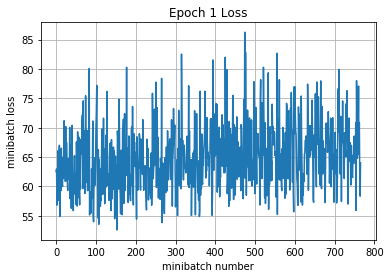

Validation
Epoch 1, Overall loss = 1.76 and accuracy of 0.693
Iteration 0: with minibatch training loss = 0.892 and accuracy of 0.94
Iteration 100: with minibatch training loss = 0.834 and accuracy of 0.97
Iteration 200: with minibatch training loss = 0.992 and accuracy of 0.91
Iteration 300: with minibatch training loss = 0.954 and accuracy of 0.91
Iteration 400: with minibatch training loss = 1.06 and accuracy of 0.88
Iteration 500: with minibatch training loss = 0.868 and accuracy of 0.95
Iteration 600: with minibatch training loss = 1.09 and accuracy of 0.84
Iteration 700: with minibatch training loss = 0.972 and accuracy of 0.91
Epoch 1, Overall loss = 0.975 and accuracy of 0.897


Validation
Epoch 1, Overall loss = 1.72 and accuracy of 0.694
Iteration 0: with minibatch training loss = 0.877 and accuracy of 0.94
Iteration 100: with minibatch training loss = 1.1 and accuracy of 0.81
Iteration 200: with minibatch training loss = 0.914 and accuracy of 0.95
Iteration 300: with minibatch training loss = 0.988 and accuracy of 0.91
Iteration 400: with minibatch training loss = 0.894 and accuracy of 0.92
Iteration 500: with minibatch training loss = 0.915 and accuracy of 0.91
Iteration 600: with minibatch training loss = 0.945 and accuracy of 0.92
Iteration 700: with minibatch training loss = 0.899 and accuracy of 0.91
Epoch 1, Overall loss = 0.936 and accuracy of 0.907


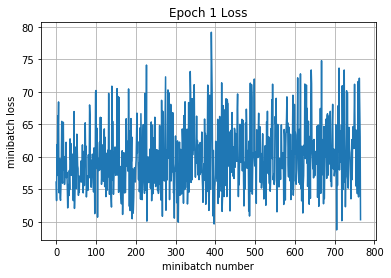

Validation
Epoch 1, Overall loss = 1.76 and accuracy of 0.685
Iteration 0: with minibatch training loss = 0.926 and accuracy of 0.91
Iteration 100: with minibatch training loss = 0.836 and accuracy of 0.92
Iteration 200: with minibatch training loss = 0.949 and accuracy of 0.91
Iteration 300: with minibatch training loss = 0.901 and accuracy of 0.89
Iteration 400: with minibatch training loss = 0.777 and accuracy of 0.97
Iteration 500: with minibatch training loss = 0.884 and accuracy of 0.94
Iteration 600: with minibatch training loss = 1.01 and accuracy of 0.84
Iteration 700: with minibatch training loss = 0.972 and accuracy of 0.89
Epoch 1, Overall loss = 0.905 and accuracy of 0.912


Validation
Epoch 1, Overall loss = 1.79 and accuracy of 0.698
Iteration 0: with minibatch training loss = 0.794 and accuracy of 0.97
Iteration 100: with minibatch training loss = 0.906 and accuracy of 0.92
Iteration 200: with minibatch training loss = 0.829 and accuracy of 0.95
Iteration 300: with minibatch training loss = 0.774 and accuracy of 0.97
Iteration 400: with minibatch training loss = 0.84 and accuracy of 0.92
Iteration 500: with minibatch training loss = 0.838 and accuracy of 0.91
Iteration 600: with minibatch training loss = 0.861 and accuracy of 0.89
Iteration 700: with minibatch training loss = 0.813 and accuracy of 0.94
Epoch 1, Overall loss = 0.878 and accuracy of 0.918


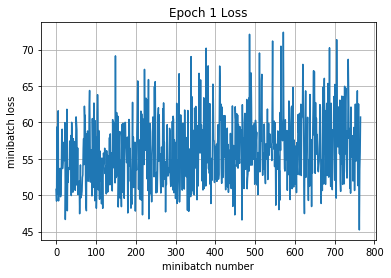

Validation
Epoch 1, Overall loss = 1.83 and accuracy of 0.684
Iteration 0: with minibatch training loss = 0.842 and accuracy of 0.95
Iteration 100: with minibatch training loss = 0.869 and accuracy of 0.92
Iteration 200: with minibatch training loss = 0.75 and accuracy of 0.97
Iteration 300: with minibatch training loss = 0.975 and accuracy of 0.92
Iteration 400: with minibatch training loss = 0.844 and accuracy of 0.94
Iteration 500: with minibatch training loss = 0.822 and accuracy of 0.91
Iteration 600: with minibatch training loss = 0.845 and accuracy of 0.89
Iteration 700: with minibatch training loss = 1.09 and accuracy of 0.83
Epoch 1, Overall loss = 0.85 and accuracy of 0.924


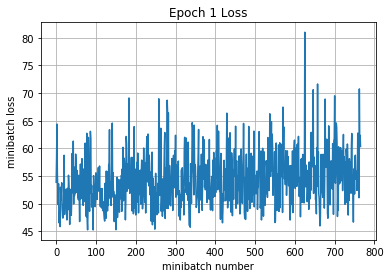

Validation
Epoch 1, Overall loss = 1.83 and accuracy of 0.662
Iteration 0: with minibatch training loss = 0.842 and accuracy of 0.94
Iteration 100: with minibatch training loss = 0.791 and accuracy of 0.94
Iteration 200: with minibatch training loss = 0.839 and accuracy of 0.94
Iteration 300: with minibatch training loss = 0.766 and accuracy of 0.95
Iteration 400: with minibatch training loss = 0.891 and accuracy of 0.89
Iteration 500: with minibatch training loss = 0.819 and accuracy of 0.89
Iteration 600: with minibatch training loss = 0.74 and accuracy of 0.97
Iteration 700: with minibatch training loss = 0.82 and accuracy of 0.95
Epoch 1, Overall loss = 0.823 and accuracy of 0.928


Validation
Epoch 1, Overall loss = 1.79 and accuracy of 0.684
Iteration 0: with minibatch training loss = 0.817 and accuracy of 0.92
Iteration 100: with minibatch training loss = 0.729 and accuracy of 0.97
Iteration 200: with minibatch training loss = 0.801 and accuracy of 0.92
Iteration 300: with minibatch training loss = 0.7 and accuracy of 1
Iteration 400: with minibatch training loss = 0.804 and accuracy of 0.95
Iteration 500: with minibatch training loss = 0.802 and accuracy of 0.94
Iteration 600: with minibatch training loss = 0.787 and accuracy of 0.92
Iteration 700: with minibatch training loss = 0.738 and accuracy of 0.95
Epoch 1, Overall loss = 0.807 and accuracy of 0.931


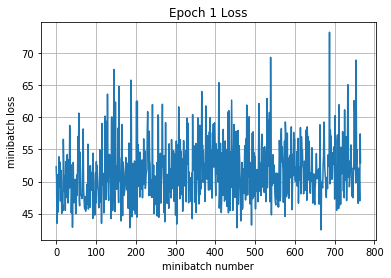

Validation
Epoch 1, Overall loss = 1.75 and accuracy of 0.691
Iteration 0: with minibatch training loss = 0.806 and accuracy of 0.92
Iteration 100: with minibatch training loss = 0.768 and accuracy of 0.94
Iteration 200: with minibatch training loss = 0.889 and accuracy of 0.89
Iteration 300: with minibatch training loss = 0.761 and accuracy of 0.94
Iteration 400: with minibatch training loss = 0.719 and accuracy of 0.97
Iteration 500: with minibatch training loss = 0.804 and accuracy of 0.91
Iteration 600: with minibatch training loss = 0.795 and accuracy of 0.94
Iteration 700: with minibatch training loss = 0.856 and accuracy of 0.91
Epoch 1, Overall loss = 0.781 and accuracy of 0.935


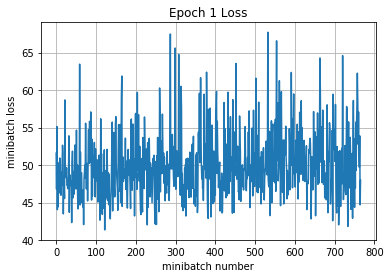

Validation
Epoch 1, Overall loss = 1.76 and accuracy of 0.695
Iteration 0: with minibatch training loss = 0.693 and accuracy of 0.95
Iteration 100: with minibatch training loss = 0.714 and accuracy of 0.95
Iteration 200: with minibatch training loss = 0.875 and accuracy of 0.92
Iteration 300: with minibatch training loss = 0.766 and accuracy of 0.92
Iteration 400: with minibatch training loss = 0.767 and accuracy of 0.94
Iteration 500: with minibatch training loss = 0.764 and accuracy of 0.94
Iteration 600: with minibatch training loss = 0.997 and accuracy of 0.88
Iteration 700: with minibatch training loss = 0.749 and accuracy of 0.94
Epoch 1, Overall loss = 0.767 and accuracy of 0.938


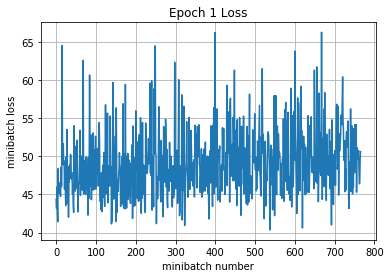

Validation
Epoch 1, Overall loss = 1.78 and accuracy of 0.684
Iteration 0: with minibatch training loss = 0.681 and accuracy of 0.97
Iteration 100: with minibatch training loss = 0.663 and accuracy of 0.98
Iteration 200: with minibatch training loss = 0.695 and accuracy of 0.95
Iteration 300: with minibatch training loss = 0.693 and accuracy of 0.94
Iteration 400: with minibatch training loss = 0.82 and accuracy of 0.92
Iteration 500: with minibatch training loss = 0.712 and accuracy of 0.94
Iteration 600: with minibatch training loss = 0.761 and accuracy of 0.95
Iteration 700: with minibatch training loss = 0.664 and accuracy of 0.97
Epoch 1, Overall loss = 0.746 and accuracy of 0.941


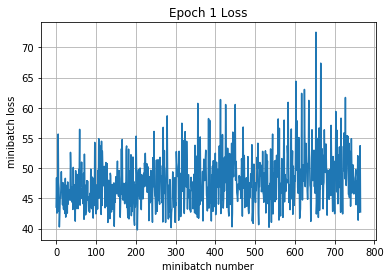

Validation
Epoch 1, Overall loss = 1.76 and accuracy of 0.688
Iteration 0: with minibatch training loss = 0.656 and accuracy of 0.97
Iteration 100: with minibatch training loss = 0.754 and accuracy of 0.91
Iteration 200: with minibatch training loss = 0.728 and accuracy of 0.97
Iteration 300: with minibatch training loss = 0.722 and accuracy of 0.94
Iteration 400: with minibatch training loss = 0.781 and accuracy of 0.95
Iteration 500: with minibatch training loss = 0.757 and accuracy of 0.95
Iteration 600: with minibatch training loss = 0.685 and accuracy of 0.97
Iteration 700: with minibatch training loss = 0.722 and accuracy of 0.95
Epoch 1, Overall loss = 0.73 and accuracy of 0.943


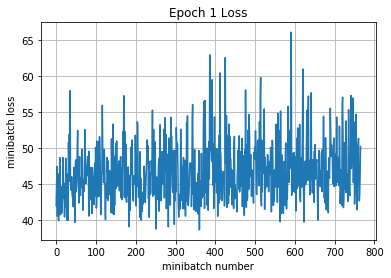

Validation
Epoch 1, Overall loss = 1.9 and accuracy of 0.662
Iteration 0: with minibatch training loss = 0.826 and accuracy of 0.89
Iteration 100: with minibatch training loss = 0.644 and accuracy of 0.98
Iteration 200: with minibatch training loss = 0.747 and accuracy of 0.91
Iteration 300: with minibatch training loss = 0.677 and accuracy of 0.97
Iteration 400: with minibatch training loss = 0.635 and accuracy of 0.98
Iteration 500: with minibatch training loss = 0.638 and accuracy of 0.98
Iteration 600: with minibatch training loss = 0.791 and accuracy of 0.94
Iteration 700: with minibatch training loss = 0.954 and accuracy of 0.8
Epoch 1, Overall loss = 0.719 and accuracy of 0.944


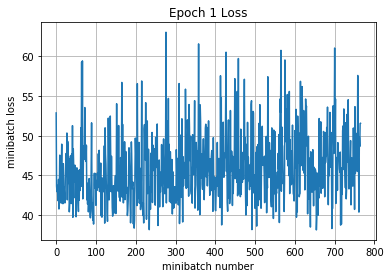

Validation
Epoch 1, Overall loss = 1.82 and accuracy of 0.695
Iteration 0: with minibatch training loss = 0.644 and accuracy of 0.98
Iteration 100: with minibatch training loss = 0.703 and accuracy of 0.94
Iteration 200: with minibatch training loss = 0.648 and accuracy of 0.98
Iteration 300: with minibatch training loss = 0.604 and accuracy of 0.98
Iteration 400: with minibatch training loss = 0.695 and accuracy of 0.95
Iteration 500: with minibatch training loss = 0.691 and accuracy of 0.98
Iteration 600: with minibatch training loss = 0.728 and accuracy of 0.94
Iteration 700: with minibatch training loss = 0.649 and accuracy of 0.97
Epoch 1, Overall loss = 0.702 and accuracy of 0.946


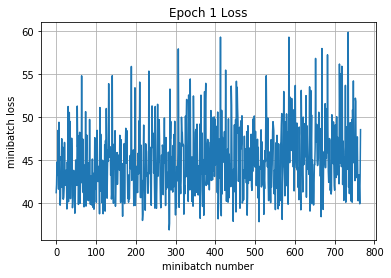

Validation
Epoch 1, Overall loss = 1.79 and accuracy of 0.693
Iteration 0: with minibatch training loss = 0.64 and accuracy of 0.98
Iteration 100: with minibatch training loss = 0.642 and accuracy of 0.95
Iteration 200: with minibatch training loss = 0.754 and accuracy of 0.91
Iteration 300: with minibatch training loss = 0.574 and accuracy of 1
Iteration 400: with minibatch training loss = 0.625 and accuracy of 0.98
Iteration 500: with minibatch training loss = 0.626 and accuracy of 0.97
Iteration 600: with minibatch training loss = 0.67 and accuracy of 0.95
Iteration 700: with minibatch training loss = 0.637 and accuracy of 0.95
Epoch 1, Overall loss = 0.685 and accuracy of 0.949


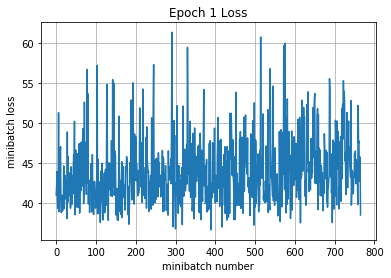

Validation
Epoch 1, Overall loss = 1.72 and accuracy of 0.698
Iteration 0: with minibatch training loss = 0.659 and accuracy of 0.97
Iteration 100: with minibatch training loss = 0.609 and accuracy of 0.98
Iteration 200: with minibatch training loss = 0.628 and accuracy of 0.95
Iteration 300: with minibatch training loss = 0.659 and accuracy of 0.95
Iteration 400: with minibatch training loss = 0.783 and accuracy of 0.92
Iteration 500: with minibatch training loss = 0.692 and accuracy of 0.92
Iteration 600: with minibatch training loss = 0.709 and accuracy of 0.94
Iteration 700: with minibatch training loss = 0.724 and accuracy of 0.95
Epoch 1, Overall loss = 0.672 and accuracy of 0.95


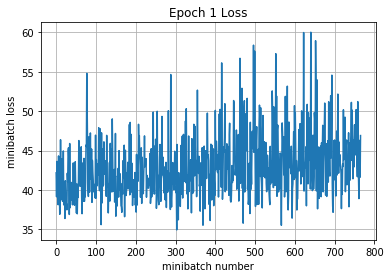

Validation
Epoch 1, Overall loss = 1.77 and accuracy of 0.686
Iteration 0: with minibatch training loss = 0.702 and accuracy of 0.94
Iteration 100: with minibatch training loss = 0.623 and accuracy of 0.97
Iteration 200: with minibatch training loss = 0.636 and accuracy of 0.95
Iteration 300: with minibatch training loss = 0.674 and accuracy of 0.95
Iteration 400: with minibatch training loss = 0.614 and accuracy of 0.95
Iteration 500: with minibatch training loss = 0.652 and accuracy of 0.95
Iteration 600: with minibatch training loss = 0.651 and accuracy of 0.95
Iteration 700: with minibatch training loss = 0.637 and accuracy of 0.95
Epoch 1, Overall loss = 0.66 and accuracy of 0.952


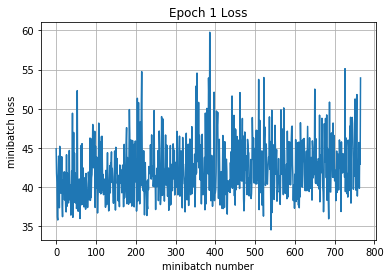

Validation
Epoch 1, Overall loss = 1.85 and accuracy of 0.678
Iteration 0: with minibatch training loss = 0.644 and accuracy of 0.94
Iteration 100: with minibatch training loss = 0.606 and accuracy of 0.97
Iteration 200: with minibatch training loss = 0.812 and accuracy of 0.91
Iteration 300: with minibatch training loss = 0.685 and accuracy of 0.94
Iteration 400: with minibatch training loss = 0.683 and accuracy of 0.94
Iteration 500: with minibatch training loss = 0.793 and accuracy of 0.86
Iteration 600: with minibatch training loss = 0.754 and accuracy of 0.91
Iteration 700: with minibatch training loss = 0.67 and accuracy of 0.94
Epoch 1, Overall loss = 0.65 and accuracy of 0.953


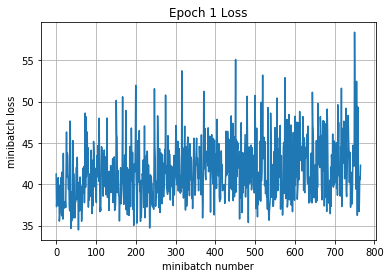

Validation
Epoch 1, Overall loss = 1.77 and accuracy of 0.657
Iteration 0: with minibatch training loss = 0.599 and accuracy of 0.97
Iteration 100: with minibatch training loss = 0.653 and accuracy of 0.94
Iteration 200: with minibatch training loss = 0.582 and accuracy of 0.97
Iteration 300: with minibatch training loss = 0.631 and accuracy of 0.95
Iteration 400: with minibatch training loss = 0.639 and accuracy of 0.97
Iteration 500: with minibatch training loss = 0.595 and accuracy of 0.97
Iteration 600: with minibatch training loss = 0.647 and accuracy of 0.95
Iteration 700: with minibatch training loss = 0.554 and accuracy of 1
Epoch 1, Overall loss = 0.641 and accuracy of 0.953


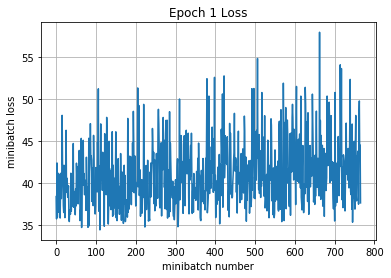

Validation
Epoch 1, Overall loss = 1.8 and accuracy of 0.678
Iteration 0: with minibatch training loss = 0.61 and accuracy of 0.97
Iteration 100: with minibatch training loss = 0.714 and accuracy of 0.92
Iteration 200: with minibatch training loss = 0.598 and accuracy of 0.95
Iteration 300: with minibatch training loss = 0.689 and accuracy of 0.95
Iteration 400: with minibatch training loss = 0.676 and accuracy of 0.94
Iteration 500: with minibatch training loss = 0.567 and accuracy of 0.98
Iteration 600: with minibatch training loss = 0.661 and accuracy of 0.95
Iteration 700: with minibatch training loss = 0.594 and accuracy of 0.95
Epoch 1, Overall loss = 0.631 and accuracy of 0.956


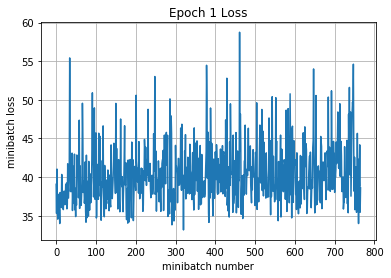

Validation
Epoch 1, Overall loss = 1.91 and accuracy of 0.661
Iteration 0: with minibatch training loss = 0.699 and accuracy of 0.94
Iteration 100: with minibatch training loss = 0.614 and accuracy of 0.95
Iteration 200: with minibatch training loss = 0.703 and accuracy of 0.92
Iteration 300: with minibatch training loss = 0.731 and accuracy of 0.89
Iteration 400: with minibatch training loss = 0.609 and accuracy of 0.94
Iteration 500: with minibatch training loss = 0.63 and accuracy of 0.94
Iteration 600: with minibatch training loss = 0.591 and accuracy of 0.97
Iteration 700: with minibatch training loss = 0.698 and accuracy of 0.94
Epoch 1, Overall loss = 0.62 and accuracy of 0.955


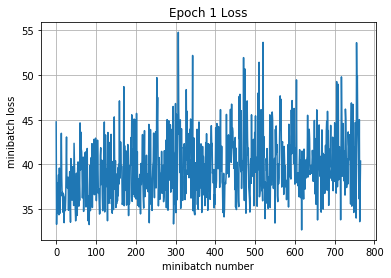

Validation
Epoch 1, Overall loss = 1.78 and accuracy of 0.691
Iteration 0: with minibatch training loss = 0.593 and accuracy of 0.98
Iteration 100: with minibatch training loss = 0.584 and accuracy of 0.97
Iteration 200: with minibatch training loss = 0.544 and accuracy of 1
Iteration 300: with minibatch training loss = 0.645 and accuracy of 0.94
Iteration 400: with minibatch training loss = 0.646 and accuracy of 0.94
Iteration 500: with minibatch training loss = 0.727 and accuracy of 0.89
Iteration 600: with minibatch training loss = 0.694 and accuracy of 0.92
Iteration 700: with minibatch training loss = 0.602 and accuracy of 0.95
Epoch 1, Overall loss = 0.611 and accuracy of 0.956


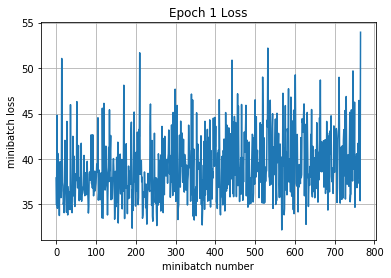

Validation
Epoch 1, Overall loss = 1.82 and accuracy of 0.671
Iteration 0: with minibatch training loss = 0.601 and accuracy of 0.94
Iteration 100: with minibatch training loss = 0.568 and accuracy of 0.97
Iteration 200: with minibatch training loss = 0.551 and accuracy of 0.98
Iteration 300: with minibatch training loss = 0.565 and accuracy of 0.98
Iteration 400: with minibatch training loss = 0.543 and accuracy of 0.97
Iteration 500: with minibatch training loss = 0.641 and accuracy of 0.92
Iteration 600: with minibatch training loss = 0.594 and accuracy of 0.95
Iteration 700: with minibatch training loss = 0.684 and accuracy of 0.89
Epoch 1, Overall loss = 0.602 and accuracy of 0.957


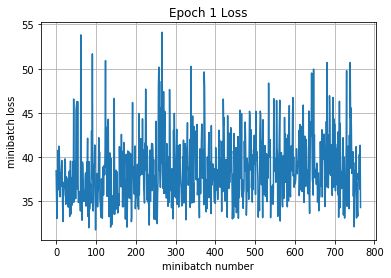

Validation
Epoch 1, Overall loss = 1.73 and accuracy of 0.691
Iteration 0: with minibatch training loss = 0.552 and accuracy of 0.98
Iteration 100: with minibatch training loss = 0.61 and accuracy of 0.95
Iteration 200: with minibatch training loss = 0.558 and accuracy of 0.97
Iteration 300: with minibatch training loss = 0.599 and accuracy of 0.95
Iteration 400: with minibatch training loss = 0.628 and accuracy of 0.95
Iteration 500: with minibatch training loss = 0.593 and accuracy of 0.95
Iteration 600: with minibatch training loss = 0.689 and accuracy of 0.92
Iteration 700: with minibatch training loss = 0.655 and accuracy of 0.92
Epoch 1, Overall loss = 0.594 and accuracy of 0.957


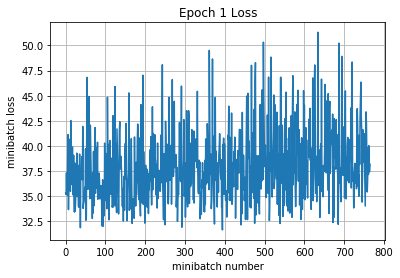

Validation
Epoch 1, Overall loss = 1.79 and accuracy of 0.681
Iteration 0: with minibatch training loss = 0.556 and accuracy of 0.97
Iteration 100: with minibatch training loss = 0.569 and accuracy of 0.94
Iteration 200: with minibatch training loss = 0.616 and accuracy of 0.95
Iteration 300: with minibatch training loss = 0.591 and accuracy of 0.95
Iteration 400: with minibatch training loss = 0.625 and accuracy of 0.97
Iteration 500: with minibatch training loss = 0.562 and accuracy of 0.97
Iteration 600: with minibatch training loss = 0.586 and accuracy of 0.98
Iteration 700: with minibatch training loss = 0.578 and accuracy of 0.98
Epoch 1, Overall loss = 0.586 and accuracy of 0.958


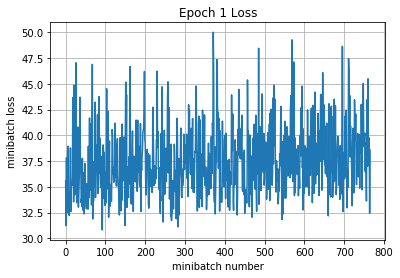

Validation
Epoch 1, Overall loss = 1.72 and accuracy of 0.681
Iteration 0: with minibatch training loss = 0.528 and accuracy of 1
Iteration 100: with minibatch training loss = 0.575 and accuracy of 0.98
Iteration 200: with minibatch training loss = 0.517 and accuracy of 0.98
Iteration 300: with minibatch training loss = 0.596 and accuracy of 0.95
Iteration 400: with minibatch training loss = 0.525 and accuracy of 0.98
Iteration 500: with minibatch training loss = 0.558 and accuracy of 0.95
Iteration 600: with minibatch training loss = 0.562 and accuracy of 0.97
Iteration 700: with minibatch training loss = 0.591 and accuracy of 0.97
Epoch 1, Overall loss = 0.579 and accuracy of 0.959


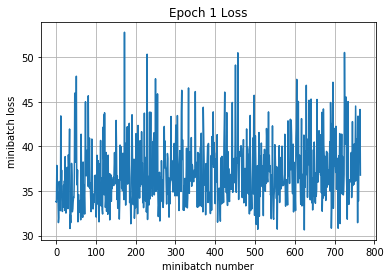

Validation
Epoch 1, Overall loss = 1.77 and accuracy of 0.683
Iteration 0: with minibatch training loss = 0.507 and accuracy of 0.98
Iteration 100: with minibatch training loss = 0.506 and accuracy of 1
Iteration 200: with minibatch training loss = 0.575 and accuracy of 0.95
Iteration 300: with minibatch training loss = 0.577 and accuracy of 0.95
Iteration 400: with minibatch training loss = 0.543 and accuracy of 0.97
Iteration 500: with minibatch training loss = 0.528 and accuracy of 0.95
Iteration 600: with minibatch training loss = 0.618 and accuracy of 0.94
Iteration 700: with minibatch training loss = 0.558 and accuracy of 0.95
Epoch 1, Overall loss = 0.574 and accuracy of 0.957


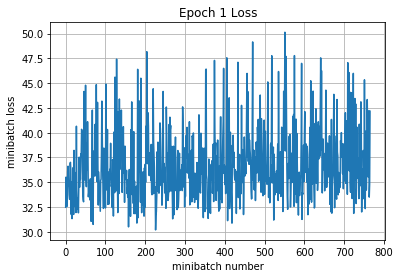

Validation
Epoch 1, Overall loss = 1.74 and accuracy of 0.676
Iteration 0: with minibatch training loss = 0.52 and accuracy of 0.98
Iteration 100: with minibatch training loss = 0.602 and accuracy of 0.97
Iteration 200: with minibatch training loss = 0.495 and accuracy of 1
Iteration 300: with minibatch training loss = 0.5 and accuracy of 0.98
Iteration 400: with minibatch training loss = 0.52 and accuracy of 0.98
Iteration 500: with minibatch training loss = 0.515 and accuracy of 0.98
Iteration 600: with minibatch training loss = 0.592 and accuracy of 0.95
Iteration 700: with minibatch training loss = 0.631 and accuracy of 0.91
Epoch 1, Overall loss = 0.564 and accuracy of 0.96


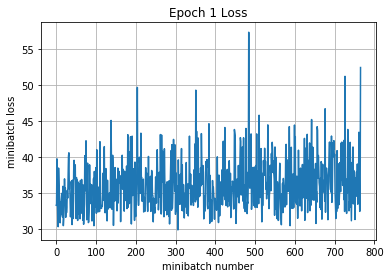

Validation
Epoch 1, Overall loss = 1.78 and accuracy of 0.66
Iteration 0: with minibatch training loss = 0.58 and accuracy of 0.97
Iteration 100: with minibatch training loss = 0.482 and accuracy of 0.98
Iteration 200: with minibatch training loss = 0.575 and accuracy of 0.92
Iteration 300: with minibatch training loss = 0.607 and accuracy of 0.92
Iteration 400: with minibatch training loss = 0.49 and accuracy of 0.97
Iteration 500: with minibatch training loss = 0.643 and accuracy of 0.92
Iteration 600: with minibatch training loss = 0.516 and accuracy of 0.98
Iteration 700: with minibatch training loss = 0.532 and accuracy of 0.97
Epoch 1, Overall loss = 0.555 and accuracy of 0.961


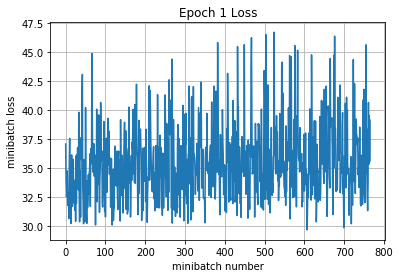

Validation
Epoch 1, Overall loss = 1.7 and accuracy of 0.685
Iteration 0: with minibatch training loss = 0.501 and accuracy of 0.97
Iteration 100: with minibatch training loss = 0.585 and accuracy of 0.94
Iteration 200: with minibatch training loss = 0.548 and accuracy of 0.97
Iteration 300: with minibatch training loss = 0.843 and accuracy of 0.88
Iteration 400: with minibatch training loss = 0.611 and accuracy of 0.94
Iteration 500: with minibatch training loss = 0.514 and accuracy of 0.97
Iteration 600: with minibatch training loss = 0.574 and accuracy of 0.98
Iteration 700: with minibatch training loss = 0.57 and accuracy of 0.94
Epoch 1, Overall loss = 0.553 and accuracy of 0.96


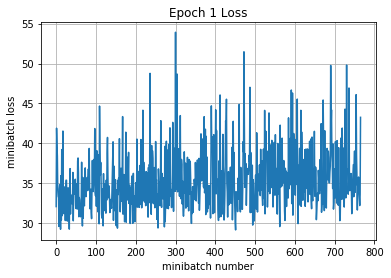

Validation
Epoch 1, Overall loss = 1.79 and accuracy of 0.687


In [60]:
#lr = 0.1
reg = 0.01
mom = 0.9
rms_lr = 1e-4
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = residual_net_model(X, y, is_training, 5)

def mean_loss_function(y_out, y, reg):
    l2_regularizer = []
    for var in tf.trainable_variables():
        if var.op.name.find('W') > 0:
            l2_regularizer.append(tf.nn.l2_loss(var))
    total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y,10),logits=y_out)
    res = tf.reduce_mean(total_loss)
    res += tf.multiply(reg, tf.add_n(l2_regularizer))
    return res

mean_loss = mean_loss_function(y_out, y, reg)
#optimizer = tf.train.MomentumOptimizer(lr, mom)
optimizer = tf.train.RMSPropOptimizer(rms_lr)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

saver = tf.train.Saver()
val_loss = 0.0
best_correct = 0.0

with tf.Session() as sess:
    with tf.device("/gpu:0"):
        sess.run(tf.global_variables_initializer())
        for e in range(50):
            run_model(sess, y_out, mean_loss, X_train, y_train, 
                      1, 64, 100, train_step, True)
            print('Validation')
            val_loss, val_correct = run_model(sess, y_out, mean_loss, X_val, y_val, 
                                              1, 64)
            if val_correct > best_correct:
                best_correct = val_correct
                save_path = saver.save(sess, "models/epoch_%d" % e)
                print("Model saved in file: %s" % save_path)

In [54]:
with tf.Session() as sess:
    # find the best models from saved ones
    for i in range(35, 40):
        check_point = "models/epoch_%d" % i
        saver.restore(sess, check_point)
        print("Model restored from")
        run_model(sess, y_out, mean_loss, X_val, y_val, 1, 64)

Model restored from
Epoch 1, Overall loss = 2.65 and accuracy of 0.64
Model restored from
Epoch 1, Overall loss = 2.77 and accuracy of 0.636
Model restored from
Epoch 1, Overall loss = 2.68 and accuracy of 0.643
Model restored from
Epoch 1, Overall loss = 2.76 and accuracy of 0.638
Model restored from
Epoch 1, Overall loss = 2.67 and accuracy of 0.651


In [62]:
# Test your model here, and make sure 
# the output of this cell is the accuracy
# of your best model on the training and val sets
# We're looking for >= 70% accuracy on Validation
with tf.Session() as sess:
    with tf.device("/gpu:0"):
        check_point = "models/epoch_%d" % 17
        saver.restore(sess, check_point)
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Epoch 1, Overall loss = 1.04 and accuracy of 0.903
Validation
Epoch 1, Overall loss = 1.69 and accuracy of 0.706


### Describe what you did here
In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network

I implmemented ResNet with 32 layers as described in section 4.2 of [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf) with the pre-activation residual unit as described [Identity Mapping in Residual Networks](https://arxiv.org/pdf/1512.03385.pdf). The differences are:

* RMSProp is used instead of SGD with momentum. Given a sample of cifar10 data, the former shows better convergence on the training set then all combination of (learning_rate, momentum) I tried, including the recommended (0.1, 0.9) in the paper.

* Training/testing data set is split 49k/1k instead of 45k/5k. No data augmentation is performed other than centering along the color chanel dimension.

* the network run for ~30k iterations, with checkpoint after each epoch and 5 network with best validation accuracy is saved. 


### Test Set - Do this only once
Now that we've gotten a result that we're happy with, we test our final model on the test set. This would be the score we would achieve on a competition. Think about how this compares to your validation set accuracy.

In [65]:
with tf.Session() as sess:
    with tf.device("/gpu:0"):
        check_point = "models/epoch_%d" % 17
        saver.restore(sess, check_point)
        print('Test')
        run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

Test
Epoch 1, Overall loss = 1.7 and accuracy of 0.696


## Going further with TensorFlow

The next assignment will make heavy use of TensorFlow. You might also find it useful for your projects. 


# Extra Credit Description
If you implement any additional features for extra credit, clearly describe them here with pointers to any code in this or other files if applicable.